In [100]:
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted
from sklearn.preprocessing import TargetEncoder

#### Getting the data and Preparing Data


In [101]:
def wrangle(db_path):
    # connect to database
    conn = sqlite3.connect(db_path)

    # construct query
    query = """
    SELECT DISTINCT i.building_id AS b_id, s.*, d.damage_grade
    FROM id_map as i
    JOIN building_structure as s ON i.building_id = s.building_id
    JOIN building_damage as d ON i.building_id = d.building_id
    WHERE district_id = 4
    """
    # Read query results into a dataframe
    df = pd.read_sql(query, conn, index_col="b_id")

    #Identify Leaky Features
    drop_cols = [col for col in df.columns if "post_eq" in col]

    #Create Binary Target
    # df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
    df["damage_grade"] = df["damage_grade"].str.replace("Grade", "").str.strip().astype(int)
    df["severe_damage"] = (df["damage_grade"] > 3).astype(int)
    drop_cols.append("damage_grade")

    #Drop multicollinearity column
    drop_cols.append("count_floors_pre_eq")

    #Drop high-cardinality categorical column
    drop_cols.append("building_id")

    #Drop Columns
    df.drop(columns=drop_cols, inplace=True)

    return df

In [102]:
df = wrangle("./data/nepal.sqlite")
df.head()

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,
164002,20,560,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164081,21,200,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164089,18,315,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164098,45,290,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164103,21,230,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0


In [103]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 70836 entries, 164002 to 234835
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   age_building            70836 non-null  int64 
 1   plinth_area_sq_ft       70836 non-null  int64 
 2   height_ft_pre_eq        70836 non-null  int64 
 3   land_surface_condition  70836 non-null  object
 4   foundation_type         70836 non-null  object
 5   roof_type               70836 non-null  object
 6   ground_floor_type       70836 non-null  object
 7   other_floor_type        70836 non-null  object
 8   position                70836 non-null  object
 9   plan_configuration      70836 non-null  object
 10  superstructure          70836 non-null  object
 11  severe_damage           70836 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 7.0+ MB
None


- Remove Leaky Features

In [104]:
# drop_cols = [col for col in df.columns if "post_eq" in col]

- Creating Target Data

In [105]:
# df["damage_grade"].head()

In [106]:
# df["damage_grade"].value_counts()

- Getting just the number of grade from the damage_grade

In [107]:
# df["damage_grade"].str.replace("Grade", "").str.strip().astype(int)

In [108]:
# df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
# df["severe_damage"] = (df["damage_grade"] > 3).astype(int)


In [109]:
df

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,
164002,20,560,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164081,21,200,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164089,18,315,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164098,45,290,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164103,21,230,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
...,...,...,...,...,...,...,...,...,...,...,...,...
234774,45,336,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Heavy roof,Mud,Timber-Planck,Attached-1 side,Rectangular,"Stone, mud mortar",1
234808,70,255,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Timber-Planck,Not attached,Rectangular,"Stone, mud mortar",1
234821,11,552,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Heavy roof,Mud,Timber-Planck,Attached-1 side,Rectangular,"Stone, mud mortar",1


#### Feature Engineering


In [110]:
# df["severe_damage"].corr(df["count_floors_pre_eq"])

In [111]:
# df["severe_damage"].corr(df["height_ft_pre_eq"])

In [112]:
# correlation = df.select_dtypes("number").drop(columns=["severe_damage"]).corr()

In [113]:
# sns.heatmap(correlation)

In [114]:
df.head()

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,
164002,20,560,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164081,21,200,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164089,18,315,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164098,45,290,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164103,21,230,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0


##### Visualization

- Boxplot for categorical vs continuous data

Text(0.5, 1.0, 'Distribution of Building Heights by Class')

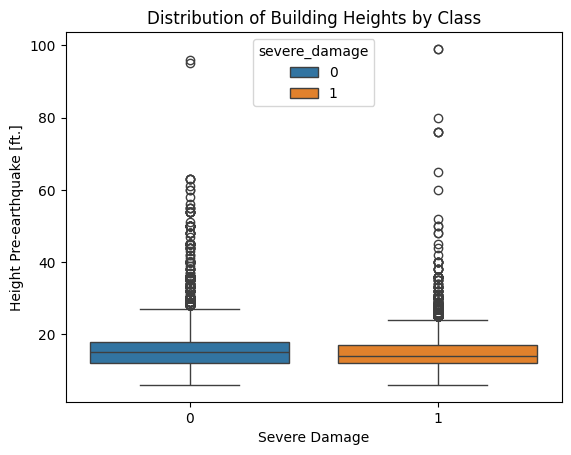

In [115]:
# Create boxplot
sns.boxplot(x="severe_damage", y="height_ft_pre_eq", data=df, hue="severe_damage")
# Label axes
plt.xlabel("Severe Damage")
plt.ylabel("Height Pre-earthquake [ft.]")
plt.title("Distribution of Building Heights by Class")

“Most buildings — whether damaged or not — had similar heights.
Some buildings were much taller than the rest (the dots), but those didn’t dominate the dataset.
Building height alone doesn’t seem to explain why some buildings had severe damage — we might need to look at other factors like material, age, or number of floors.”

<Axes: title={'center': 'Class Balance'}, xlabel='Class', ylabel='Relative Frequency'>

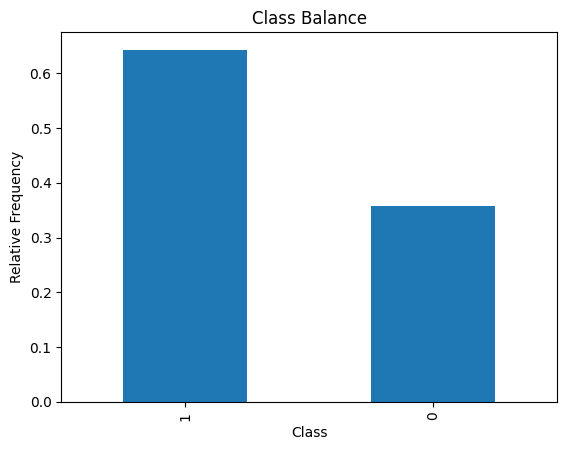

In [116]:
df["severe_damage"].value_counts(normalize=True).plot(
    kind="bar", xlabel="Class", ylabel="Relative Frequency", title="Class Balance"
)

- Majority and Minority Classes

In our case, 1 is the majority class(The building that are severly damaged) and 0 are the minority class( The buildings that are not severely damaged)

In [117]:
majority_class_prop, minority_class_prop = df["severe_damage"].value_counts(normalize=True)
print(majority_class_prop, minority_class_prop)

0.6425969845841097 0.3574030154158902


<h4 style="color: yellow"> Pivot Table </h4>

In [118]:
foundation_pivot = pd.pivot_table(
    df, index="foundation_type",values="severe_damage",aggfunc="mean"
).sort_values(by="severe_damage")
foundation_pivot

,severe_damage
foundation_type,
RC,0.026224
Bamboo/Timber,0.324074
Cement-Stone/Brick,0.421908
Mud mortar-Stone/Brick,0.687792
Other,0.818898


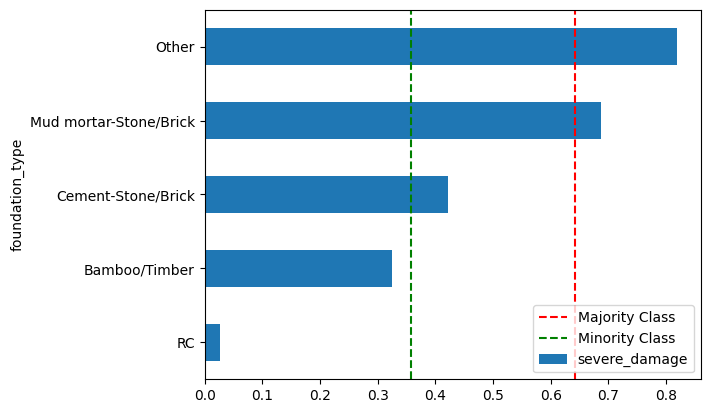

In [119]:
foundation_pivot.plot(kind="barh", legend=None)
plt.axvline(
    majority_class_prop, linestyle="--", color="red", label="Majority Class"
)
plt.axvline(
    minority_class_prop, linestyle="--", color="green", label= "Minority Class"
)
plt.legend(loc="lower right")

- Check for high and low cardinality categorical features

In [120]:
df.select_dtypes("object").nunique()

land_surface_condition     3
foundation_type            5
roof_type                  3
ground_floor_type          5
other_floor_type           4
position                   4
plan_configuration        10
superstructure            11
dtype: int64

In [121]:
df.head()

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,
164002,20,560,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164081,21,200,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164089,18,315,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164098,45,290,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164103,21,230,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
